# New Movie Studio Recommendations

**Authors:** Janice Teguh
***

## Overview

This project analyzes the recent landscape and trends of the movie industry to form recommendations for Microsoft's new movie studio. Descriptive analysis of box office data shows that there are correlations between the performance of a movie release with seasonality, popularity, and genre. Microsoft can use this analysis to adjust their planning of first movie release to improve chances of getting a box office/ high domestic and foreign gross.

## Business Problem

Microsoft is looking to expand their business into the movie industry, but lack the knowledge of the recent trends or landscape. This knowledge is essential for forming a strategy for a successful first movie release. Using box office and ratings data from The Numbers, Box Office Mojo, Rotten Tomatoes, TheMovieDB, and IMDb, I describe correlations between seasonality, popularity, and genre of a movie with its performance in box office - which Microsoft can use in planning for their first movie.

## Data Understanding

- Data from The Numbers consists of movie id, release date, titles, production budget, domestic gross, worldwide gross
- Data from Box Office Mojo consists of movie title, studio, domestic gross, and foreign gross
- Data from Rotten Tomatoes (Info) consists of movie id, synopsis, rating, genre, director, writer, theater date, box office, runtime, studio
- Data from Rotten Tomatoes (Review) consists of movie id, review, rating, fresh, critic, top_critic, publisher, date
- Data from The Movie Database consists of genre ids, movie id, original language, original title, popularity, release date, title, vote average, vote count
- Data from IMDb consists of many tables consisting of movie title, number of votes, average rating, regions the movie was released in, and people involved in the movie production.

The properties that I will focus on for this analysis are release season, domestic gross, foreign and worldwide gross, genre,  box office, and audience reception.

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sqlite3

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

%matplotlib inline

In [2]:
#load data from The Numbers
movie_budgets = pd.read_csv('./Data/tn.movie_budgets.csv')
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [3]:
#load data from Box Office Mojo
movie_gross = pd.read_csv('./Data/bom.movie_gross.csv')
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [4]:
#load data from Rotten Tomatoes movie info and reviews
movie_info = pd.read_csv('./Data/rt.movie_info.tsv', sep='\t')
rt_reviews = pd.read_csv('./Data/rt.reviews.tsv', sep='\t', encoding='windows-1252')

#for one movie id, there are a couple reviews. Need to merge reviews before merging rt_reviews with movie info

In [5]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [6]:
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [7]:
#load data from The Movie Database
tmdb_movies = pd.read_csv('./Data/tmdb.movies.csv')

In [8]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [9]:
#opening im.db
conn = sqlite3.connect('./Data/im.db')
cursor = conn.cursor()

#checking all tables are imported from im.db
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers
8  movie_summary


## Data Preparation


In [10]:
#check for duplicates, resulting in no duplicates
movie_budgets = movie_budgets.loc[~movie_budgets.duplicated()]
movie_gross = movie_gross.loc[~movie_gross.duplicated()]
movie_info = movie_info.loc[~movie_info.duplicated()]
rt_reviews = rt_reviews.loc[~rt_reviews.duplicated()]
tmdb_movies = tmdb_movies.loc[~tmdb_movies.duplicated()]

In [11]:
#preparing_movie_budgets
#Set data type as date and time, convert data as required
movie_budgets["release_date"] = pd.to_datetime(movie_budgets["release_date"]) 
movie_budgets["year"] = movie_budgets["release_date"].dt.year.astype(int)
movie_budgets["month"] = movie_budgets["release_date"].dt.month.astype(int)

#rename movie column to title
movie_budgets = movie_budgets.rename(columns={"movie":"title"})
movie_budgets

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,year,month
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009,12
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,5
2,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,6
3,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,5
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017,12
...,...,...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,"$7,000",$0,$0,2018,12
5778,79,1999-04-02,Following,"$6,000","$48,482","$240,495",1999,4
5779,80,2005-07-13,Return to the Land of Wonders,"$5,000","$1,338","$1,338",2005,7
5780,81,2015-09-29,A Plague So Pleasant,"$1,400",$0,$0,2015,9


In [12]:
#remove $ and comma from currency string
def convert_currency(string):
    string = string.strip('$')
    string = string.replace(',', '')

    return string

#convert any time/date or currency column to int64 dtype
def convert_column(column):
    column = column.map(lambda x: convert_currency(x))
    column = column.astype(float)
    return column

In [13]:
#only run this cell once
movie_budgets["production_budget"] = convert_column(movie_budgets["production_budget"])
movie_budgets["domestic_gross"] = convert_column(movie_budgets["domestic_gross"])
movie_budgets["worldwide_gross"] = convert_column(movie_budgets["worldwide_gross"])

movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   title              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
 6   year               5782 non-null   int64         
 7   month              5782 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 406.5+ KB


In [14]:
#no more null values in all the columns
movie_budgets.isna().sum()

id                   0
release_date         0
title                0
production_budget    0
domestic_gross       0
worldwide_gross      0
year                 0
month                0
dtype: int64

In [15]:
movie_gross

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [16]:
#preparing movie_gross
#there were 1350 NaN values in "Foreign Gross" column (almost 40%) - add value of 500 as outlier
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].fillna(value=500)
movie_gross["foreign_gross"] = [float(str(i).replace(",", "")) for i in movie_gross["foreign_gross"]]

#fill n/a values with median in domestic gross
movie_gross['domestic_gross'] = movie_gross['domestic_gross'].fillna(value=movie_gross['domestic_gross'].median())

#rename N/A studios to "N/A"
movie_gross["studio"] = movie_gross["studio"].fillna(value="N/A")

movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3387 non-null   object 
 2   domestic_gross  3387 non-null   float64
 3   foreign_gross   3387 non-null   float64
 4   year            3387 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 158.8+ KB


In [17]:
movie_gross.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

In [18]:
#preparing movie_info
# removed movies that didn't make box office
movie_info = movie_info.dropna(subset=['box_office'])
movie_info.isna().sum()

#remove runtime and theatre date column with N/A values
movie_info = movie_info.dropna(subset=['runtime', "theater_date"])

#drop irrelevant columns
movie_info = movie_info.drop(["dvd_date", "currency"], axis=1)

#filling N/A values in remaining columns with N/A
movie_info["director"] = movie_info["director"].fillna("Unknown")
movie_info["writer"] = movie_info["writer"].fillna("Unknown")
movie_info["studio"] = movie_info["studio"].fillna("Unknown")
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 332 entries, 1 to 1555
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            332 non-null    int64 
 1   synopsis      332 non-null    object
 2   rating        332 non-null    object
 3   genre         332 non-null    object
 4   director      332 non-null    object
 5   writer        332 non-null    object
 6   theater_date  332 non-null    object
 7   box_office    332 non-null    object
 8   runtime       332 non-null    object
 9   studio        332 non-null    object
dtypes: int64(1), object(9)
memory usage: 28.5+ KB


In [19]:
#no more null values in movie_info
movie_info.isna().sum()

id              0
synopsis        0
rating          0
genre           0
director        0
writer          0
theater_date    0
box_office      0
runtime         0
studio          0
dtype: int64

In [20]:
movie_info["box_office"] = convert_column(movie_info["box_office"])

In [21]:
#prepare rt_reviews
rt_reviews.dropna(subset=["rating"], inplace=True)
rt_reviews.drop(["critic","publisher"],axis=1, inplace=True)

In [22]:
rt_reviews["review"] = rt_reviews["review"].fillna(value="No written review.")
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40907 entries, 0 to 54431
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          40907 non-null  int64 
 1   review      40907 non-null  object
 2   rating      40907 non-null  object
 3   fresh       40907 non-null  object
 4   top_critic  40907 non-null  int64 
 5   date        40907 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


In [23]:
#no more null values in rt_reviews
rt_reviews.isna().sum()

id            0
review        0
rating        0
fresh         0
top_critic    0
date          0
dtype: int64

In [24]:
#create singular review number for each movie id in rotten tomatoes
review_letter = {"N":0.1, "R":1, "T":0.1, "F":0.1, "A":1, "B":0.75, "C":0.5, "D":0.25 }

def change(grade):
    if "/" in grade and " " not in grade:
        numbers = grade.split("/")
        result = float(numbers[0]) / float(numbers[1])
        return result
    elif grade[0] in "ABCDNRTF":
        result = float(review_letter[grade[0]])
        return result
    elif "." in grade:
        return round(float(grade))
    else:
        return 3
        
rt_reviews["fresh_number"] = rt_reviews["rating"].apply(lambda x: float(change(x)*10))
rt_reviews

,id,review,rating,fresh,top_critic,date,fresh_number
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,0,"November 10, 2018",6.0
6,3,"Quickly grows repetitive and tiresome, meander...",C,rotten,0,"July 17, 2013",5.0
7,3,Cronenberg is not a director to be daunted by ...,2/5,rotten,0,"April 21, 2013",4.0
11,3,"While not one of Cronenberg's stronger films, ...",B-,fresh,0,"February 3, 2013",7.5
12,3,Robert Pattinson works mighty hard to make Cos...,2/4,rotten,0,"January 15, 2013",5.0
...,...,...,...,...,...,...,...
54424,2000,Dawdles and drags when it should pop; it doesn...,1.5/5,rotten,1,"September 26, 2002",3.0
54428,2000,No written review.,1/5,rotten,0,"September 21, 2005",2.0
54429,2000,No written review.,2/5,rotten,0,"July 17, 2005",4.0
54430,2000,No written review.,2.5/5,rotten,0,"September 7, 2003",5.0


In [25]:
rt_reviews_numeric = rt_reviews.groupby("id").agg({"fresh_number":"mean"})
rt_reviews_numeric

,fresh_number
id,
3,6.369469
5,6.800000
6,5.890244
8,7.575000
10,6.487705
...,...
1996,6.436957
1997,5.945652
1998,6.000000


In [26]:
#merge rotten tomatoes info with rotten tomatoes reviews
rt_merge = movie_info.merge(rt_reviews_numeric, on="id")
rt_merge.sort_values(by="box_office",ascending=False,inplace=True)
rt_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294 entries, 145 to 176
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            294 non-null    int64  
 1   synopsis      294 non-null    object 
 2   rating        294 non-null    object 
 3   genre         294 non-null    object 
 4   director      294 non-null    object 
 5   writer        294 non-null    object 
 6   theater_date  294 non-null    object 
 7   box_office    294 non-null    float64
 8   runtime       294 non-null    object 
 9   studio        294 non-null    object 
 10  fresh_number  294 non-null    float64
dtypes: float64(2), int64(1), object(8)
memory usage: 27.6+ KB


In [27]:
rt_merge.isna().sum()

id              0
synopsis        0
rating          0
genre           0
director        0
writer          0
theater_date    0
box_office      0
runtime         0
studio          0
fresh_number    0
dtype: int64

In [28]:
#Set data type as date and time, convert data as required
tmdb_movies["release_date"] = pd.to_datetime(tmdb_movies["release_date"]) 
tmdb_movies["year"] = tmdb_movies["release_date"].dt.year.astype(int)
tmdb_movies["month"] = tmdb_movies["release_date"].dt.month.astype(int)
tmdb_movies.drop(["Unnamed: 0"], axis=1, inplace=True)
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26517 entries, 0 to 26516
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          26517 non-null  object        
 1   id                 26517 non-null  int64         
 2   original_language  26517 non-null  object        
 3   original_title     26517 non-null  object        
 4   popularity         26517 non-null  float64       
 5   release_date       26517 non-null  datetime64[ns]
 6   title              26517 non-null  object        
 7   vote_average       26517 non-null  float64       
 8   vote_count         26517 non-null  int64         
 9   year               26517 non-null  int64         
 10  month              26517 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 2.4+ MB


In [29]:
#no more null values in tmdb_movies
tmdb_movies.isna().sum()

genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
year                 0
month                0
dtype: int64

In [30]:
#see table contents from all im.db tables
pd.read_sql("""SELECT * FROM movie_basics""", conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [31]:
pd.read_sql("""SELECT * FROM directors""", conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
...,...,...
291169,tt8999974,nm10122357
291170,tt9001390,nm6711477
291171,tt9001494,nm10123242
291172,tt9001494,nm10123248


In [32]:
pd.read_sql("""SELECT * FROM known_for""", conn)

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241
2,nm0061671,tt0844471
3,nm0061671,tt0118553
4,nm0061865,tt0896534
...,...,...
1638255,nm9990690,tt9090932
1638256,nm9990690,tt8737130
1638257,nm9991320,tt8734436
1638258,nm9991320,tt9615610


In [33]:
pd.read_sql("""SELECT * FROM movie_akas""", conn)

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,None,None,original,None,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,None,0.0
331700,tt9880178,1,La atención,None,None,original,None,1.0
331701,tt9880178,2,La atención,ES,None,None,None,0.0


In [34]:
pd.read_sql("""SELECT * FROM movie_ratings""", conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [35]:
pd.read_sql("""SELECT * FROM persons""", conn)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


In [36]:
pd.read_sql("""SELECT * FROM principals""", conn)

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,None,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,None,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,None,None
1028184,tt9692684,4,nm6009913,writer,writer,None


In [37]:
pd.read_sql("""SELECT * FROM writers""", conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087
...,...,...
255868,tt8999892,nm10122246
255869,tt8999974,nm10122357
255870,tt9001390,nm6711477
255871,tt9004986,nm4993825


In [38]:
#combine to make movie_summary table for data analysis
#delete movie summary table if already exists
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS movie_summary;")
conn.commit()

# Create a new table with relevant columns using LEFT JOIN

cursor.execute("""CREATE TABLE movie_summary AS
                SELECT 
                    mb.movie_id,
                    mb.genres,
                    mb.primary_title,
                    mr.averagerating,
                    GROUP_CONCAT(DISTINCT ma.region) AS regions,
                    mr.numvotes
                FROM 
                    movie_basics mb
                LEFT JOIN 
                    movie_akas ma ON mb.movie_id = ma.movie_id
                LEFT JOIN 
                    movie_ratings mr ON mb.movie_id = mr.movie_id
                GROUP BY 
                    mb.movie_id, mb.primary_title, mr.numvotes;""")
conn.commit()

In [39]:
#remove duplicates from imdb - movie summary and keep row with smallest ROWID for each movie ID

cursor.execute("""
DELETE FROM movie_summary
WHERE ROWID NOT IN (SELECT MIN(ROWID) 
                    FROM movie_summary 
                    GROUP BY movie_id);""")
conn.commit()

In [40]:
#remove rows where numvotes is NULL
cursor.execute("""DELETE FROM movie_summary
WHERE numvotes IS NULL;""")
conn.commit()

In [41]:
pd.read_sql("""SELECT * FROM movie_summary""", conn)

,movie_id,genres,primary_title,averagerating,regions,numvotes
0,tt0063540,"Action,Crime,Drama",Sunghursh,7.0,IN,77
1,tt0066787,"Biography,Drama",One Day Before the Rainy Season,7.2,"IN,XWW",43
2,tt0069049,Drama,The Other Side of the Wind,6.9,"AR,BR,DE,ES,FR,GB,IT,PL,PT,RU,US,VE",4517
3,tt0069204,"Comedy,Drama",Sabse Bada Sukh,6.1,IN,13
4,tt0100275,"Comedy,Drama,Fantasy",The Wandering Soap Opera,6.5,"CL,PL,XWW",119
...,...,...,...,...,...,...
73851,tt9913084,Documentary,Diabolik sono io,6.2,None,6
73852,tt9914286,"Drama,Family",Sokagin Çocuklari,8.7,None,136
73853,tt9914642,Documentary,Albatross,8.5,None,8
73854,tt9914942,None,La vida sense la Sara Amat,6.6,None,5


## Data Modeling

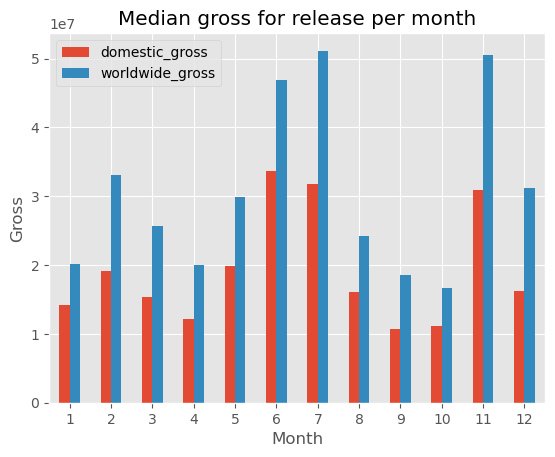

In [42]:
#With movie_budgets, plot domestic and worldwide gross against month that movie is released
df1 = movie_budgets.groupby(['month'])['domestic_gross'].median().to_frame()
df2 = movie_budgets.groupby(['month'])['worldwide_gross'].median().to_frame()


df1.merge(df2, how="inner", on="month").plot(kind="bar")
plt.xticks(rotation=0)
plt.ylabel("Gross")
plt.xlabel("Month")
plt.title("Median gross for release per month")
plt.savefig("./images/median_gross_for_release_per_month.png", dpi=150)
plt.show()

- Highest median for domestic gross is for releases in June, July, November. Roughly 100-150% more than other months.
- Highest median for worldwide gross is for releases in July, Nov, June. Roughly 150-250% more than other months.

In [89]:
# Convert month to categorical
movie_budgets["month"] = movie_budgets["month"].astype("category")

# ANOVA for Domestic Gross
domestic_model = smf.ols('domestic_gross ~ C(month)', data=movie_budgets).fit()
domestic_anova = sm.stats.anova_lm(domestic_model, typ=2)

# ANOVA for Worldwide Gross
worldwide_model = smf.ols('worldwide_gross ~ C(month)', data=movie_budgets).fit()
worldwide_anova = sm.stats.anova_lm(worldwide_model, typ=2)

domestic_anova, worldwide_anova

(                sum_sq      df          F        PR(>F)
 C(month)  1.447682e+18    11.0  29.810794  7.879718e-62
 Residual  2.547316e+19  5770.0        NaN           NaN,
                 sum_sq      df          F        PR(>F)
 C(month)  9.219830e+18    11.0  28.914878  7.361590e-60
 Residual  1.672571e+20  5770.0        NaN           NaN)

Interpretation
- The ANOVA test indicates that, with 95% confidence, there is statistically significant difference between monthly domestic gross and worldwide gross data, which suggests that release month has an impact on domestic gross and worldwide gross
- Worldwide gross is always bigger than domestic gross no matter the month. Bigger market size.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

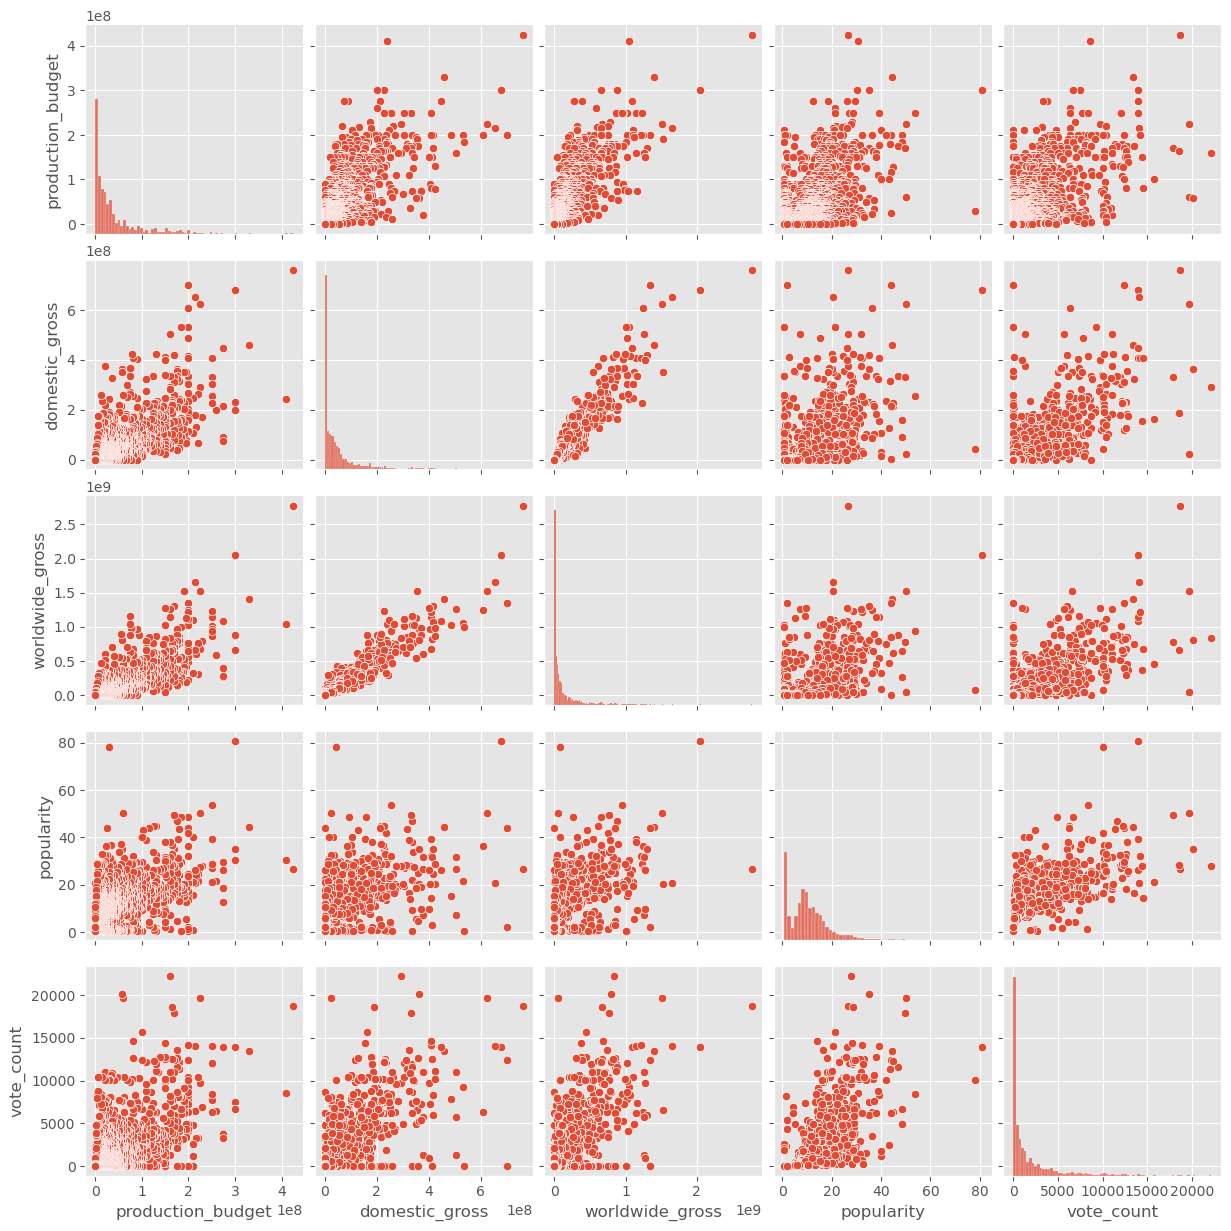

In [44]:
#check Pearson's correlation between production budget and audience engagement

# Merge on title
combined_df = pd.merge(movie_budgets, tmdb_movies, on='title', how='inner')
fig = sns.pairplot(combined_df, vars=['production_budget','domestic_gross','worldwide_gross','popularity','vote_count']);
fig.savefig("correlation matrix betweem production budget and audience engagement.png")

In [45]:
# Analyze correlation
correlations = combined_df[['production_budget', 'domestic_gross', 'worldwide_gross', 'popularity', 'vote_count']].corr();
correlations

,production_budget,domestic_gross,worldwide_gross,popularity,vote_count
production_budget,1.000000,0.717331,0.794107,0.556587,0.606330
domestic_gross,0.717331,1.000000,0.945834,0.536002,0.705910
worldwide_gross,0.794107,0.945834,1.000000,0.563912,0.723484
popularity,0.556587,0.536002,0.563912,1.000000,0.735966
vote_count,0.606330,0.705910,0.723484,0.735966,1.000000


There is a strong positive relationship between production budget and worldwide gross (0.79) and between production budget and domestic gross (0.72).

There is a moderate positive relationship between production budget and popularity (0.56) and production budget and vote count (0.6)

There is a very strong positive relationship between domestic gross and worldwide gross (0.94)

There is a moderate positive relationship between popularity and domestic gross (0.53) and moderate positive relationship between popularity and worldwide gross (0.56)

There is a strong positive relationship between vote_count and domestic gross (0.71) and between vote_count and worldwide_gross (0.72)

In [46]:
#do multi regression analysis without domestic gross 
# because domestic gross and worldwide gross are colinear
# Prepare data for regression
X = combined_df[['production_budget']]
y_vars = combined_df[['worldwide_gross', 'popularity', 'vote_count']]

# Add constant
X = sm.add_constant(X)

# Run separate regressions for each y variable and store summaries
#1 is for worlwide gross, 2 is for popularity, 3 is for vote count
regression_summaries = {}
for y_var in y_vars.columns:
    model = sm.OLS(y_vars[y_var], X).fit()
    regression_summaries[y_var] = model.summary()

regression_summaries

{'worldwide_gross': <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:        worldwide_gross   R-squared:                       0.631
 Model:                            OLS   Adj. R-squared:                  0.630
 Method:                 Least Squares   F-statistic:                     4068.
 Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
 Time:                        15:54:55   Log-Likelihood:                -48024.
 No. Observations:                2385   AIC:                         9.605e+04
 Df Residuals:                    2383   BIC:                         9.606e+04
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------

Worldwide gross:
- R-squared = 0.631
- For every \\$1.00 increase in budget > \\$3.43 increase in worldwide gross
- Highly significant (p < 0.001)

Popularity
- R-squared = 0.310
- Budget explains ~31% variance in popularity
- The impact is tiny (8.97e-08) but this is statistically significant (p<0.001)

Vote count
- R-squared = 0.368
- Budget explains ~37% of the variance in vote count
- Effect is also tiny (3.17e-05) but this finding is statistically significant

In [47]:
#find overall domestic gross median from movie_gross dataset
total_domestic_gross_median = movie_gross["domestic_gross"].median()
total_domestic_gross_median

1400000.0

In [48]:
#find overall foreign gross median from movie_gross dataset
total_foreign_gross_median = movie_gross["foreign_gross"].median()
total_foreign_gross_median

1500000.0

In [49]:
#find studios with highest domestic gross
#dataframe of studio domestic gross median of all the movies they have made
studio_domestic_gross = movie_gross.groupby(['studio'])['domestic_gross'].median().to_frame(name = 'studio_domestic_gross').reset_index()

#look for studios which median is higher or equal to total domestic gross median of the whole industry (based on dataset)
studio_doing_well = studio_domestic_gross[studio_domestic_gross["studio_domestic_gross"] >= total_domestic_gross_median]

#number of studios "doing well"
len(studio_doing_well)

71

In [50]:
studio_doing_well = studio_doing_well.sort_values(by="studio_domestic_gross").set_index("studio")

In [51]:
studio_doing_well

,studio_domestic_gross
studio,
Myr.,1400000.0
AaF,1400000.0
PI,1400000.0
CF&SR,1500000.0
Yash,1600000.0
...,...
Sony,62000000.0
Fox,62150000.0
WB (NL),63100000.0


In [52]:
#do above process to find studios with highest foreign gross

#dataframe of studio foreign gross median of all the movies they have made
studio_foreign_gross = movie_gross.groupby(['studio'])['foreign_gross'].median().to_frame(name = 'studio_foreign_gross').reset_index()

#look for studios which median is higher or equal to total foreign gross median of the whole industry (based on dataset)
studio_doing_well_foreign = studio_foreign_gross[studio_foreign_gross["studio_foreign_gross"] >= total_foreign_gross_median]

#number of studios "doing well"
len(studio_doing_well_foreign)

74

In [53]:
studio_doing_well_foreign = studio_doing_well_foreign.sort_values(by="studio_foreign_gross", ascending=False).set_index("studio")

In [54]:
studio_doing_well_foreign

,studio_foreign_gross
studio,
HC,867600000.0
P/DW,341500000.0
GrtIndia,234000000.0
WAMCR,134950000.0
BV,122750000.0
...,...
PDA,2000000.0
Imag.,1927500.0
Argo.,1800000.0


In [55]:
#combine both dfs
high_earning = studio_doing_well.merge(studio_doing_well_foreign, how="inner", on="studio")
high_earning = high_earning.dropna()
high_earning

,studio_domestic_gross,studio_foreign_gross
studio,,
Myr.,1400000.0,1800000.0
PI,1400000.0,2100000.0
UHE,1700000.0,3200000.0
SV,1800000.0,23900250.0
Amazon,2500000.0,3700000.0
Spanglish,2600000.0,5200000.0
HC,2700000.0,867600000.0
PDA,3300000.0,2000000.0
U/P,3500000.0,2800000.0


In [56]:
high_earning.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Myr. to P/DW
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   studio_domestic_gross  47 non-null     float64
 1   studio_foreign_gross   47 non-null     float64
dtypes: float64(2)
memory usage: 1.1+ KB


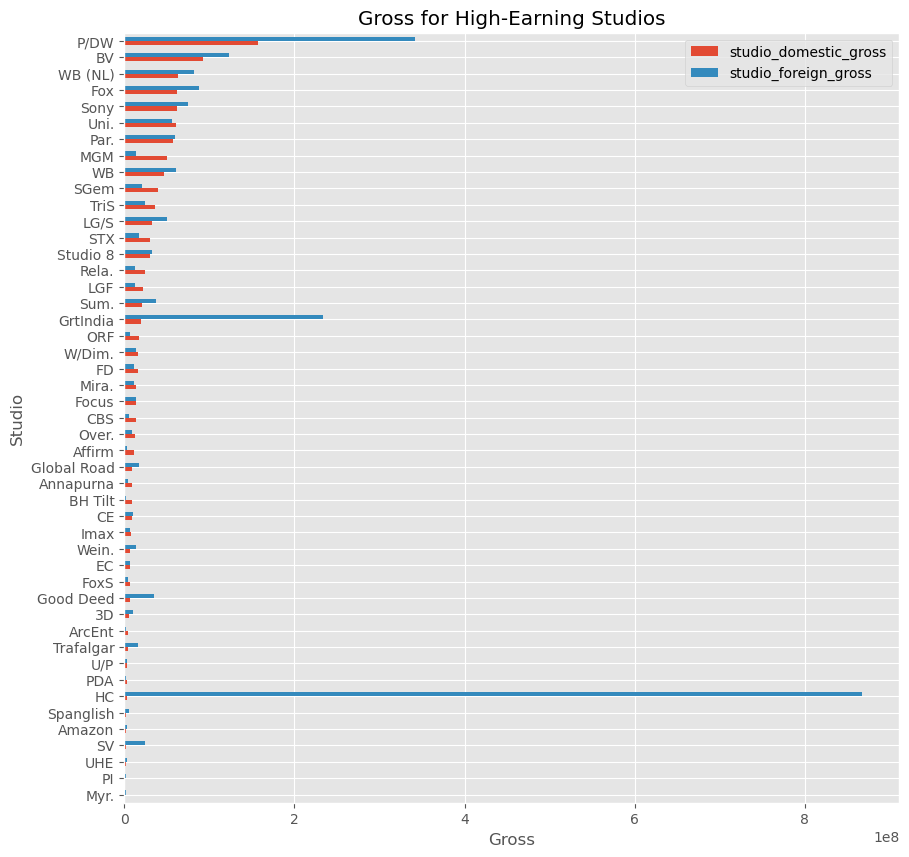

In [57]:
ax = high_earning.plot(kind="barh", figsize=(10,10))
plt.xticks(rotation=0)
plt.ylabel("Studio")
plt.xlabel("Gross")
plt.title("Gross for High-Earning Studios")
plt.savefig("./images/gross_for_high_earning_studios.png", dpi=150)
plt.show()

In [58]:
#How many movies did HC, GrtIndia, and P/DW released
movie_gross[movie_gross["studio"].isin(["HC","GrtIndia","P/DW"])]

,title,studio,domestic_gross,foreign_gross,year
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010
9,How to Train Your Dragon,P/DW,217600000.0,277300000.0,2010
17,Megamind,P/DW,148400000.0,173500000.0,2010
71,Dinner for Schmucks,P/DW,73000000.0,13800000.0,2010
329,Transformers: Dark of the Moon,P/DW,352400000.0,771400000.0,2011
333,Kung Fu Panda 2,P/DW,165200000.0,500400000.0,2011
338,Puss in Boots,P/DW,149300000.0,405700000.0,2011
734,Madagascar 3: Europe's Most Wanted,P/DW,216400000.0,530500000.0,2012
752,Rise of the Guardians,P/DW,103400000.0,203500000.0,2012
865,A Thousand Words,P/DW,18500000.0,3600000.0,2012


- Foreign gross beating domestic very significantly for HC, GrtIndia, P/DW
- HC and GrtIndia only released one movie in the dataset, but highest foreign gross. May signify that number of movies released doesn't matter, but what matters is the size of the foreign market (Chinese and Indian population globally).

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


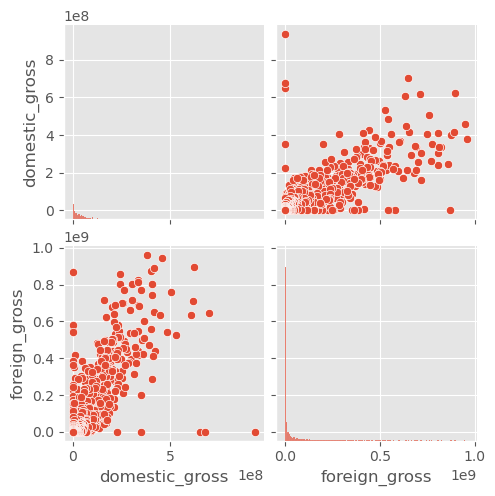

In [59]:
fig = sns.pairplot(movie_gross, vars=['domestic_gross','foreign_gross'])
fig.savefig("Correlation between domestic gross and foreign gross.png")

In [60]:
corr_matrix = movie_gross[['domestic_gross','foreign_gross']].corr()
corr_matrix

,domestic_gross,foreign_gross
domestic_gross,1.000000,0.792269
foreign_gross,0.792269,1.000000


High domestic gross strongly correlates with high foreign gross (0.79).

In [61]:
#calculate average box office in rotten tomatoes - merged
box_office_median = rt_merge["box_office"].median()
box_office_median

15671532.5

In [62]:
#filter rt_merge to only have movies making above the median
rt_merge = rt_merge[rt_merge["box_office"]>=box_office_median]
rt_merge

,id,synopsis,rating,genre,director,writer,theater_date,box_office,runtime,studio,fresh_number
145,1071,This depiction of the last 12 hours in the lif...,R,Drama,Mel Gibson,Mel Gibson|Benedict Fitzgerald,"Feb 25, 2004",368000000.0,127 minutes,Newmarket Film Group,6.825676
156,1136,The Hobbit: An Unexpected Journey follows titl...,PG-13,Action and Adventure|Science Fiction and Fantasy,Peter Jackson,Peter Jackson|Philippa Boyens|Guillermo del To...,"Dec 14, 2012",303001229.0,170 minutes,Warner Bros.,6.984474
222,1525,"In Skyfall, Bond's loyalty to M is tested as h...",PG-13,Action and Adventure|Mystery and Suspense,Sam Mendes,John Logan|Robert Wade|Neal Purvis,"Nov 9, 2012",299300000.0,145 minutes,MGM,9.121392
123,883,"Now that Greg Focker is ""in"" with his soon-to-...",PG-13,Comedy,Jay Roach,Jim Herzfeld|John Hamburg,"Dec 22, 2004",279167575.0,118 minutes,Universal Pictures,5.819915
205,1442,Youthful wizard Harry Potter returns to the sc...,PG,Kids and Family|Science Fiction and Fantasy,Chris Columbus,Steve Kloves,"Nov 15, 2002",261835892.0,161 minutes,Warner Bros. Pictures,7.831126
...,...,...,...,...,...,...,...,...,...,...,...
179,1279,A handful of kids stranded without their paren...,PG,Comedy|Kids and Family,Paul Feig,Mya Stark|Jacob Meszaros,"Dec 8, 2006",16614132.0,89 minutes,Warner Bros.,5.238718
127,903,Director James Cameron journeys back to the si...,G,Comedy|Documentary|Science Fiction and Fantasy...,James Cameron,Unknown,"Apr 11, 2003",16302332.0,59 minutes,Buena Vista Distribution,7.368421
121,864,Vacancy director Nimr,PG-13,Drama|Mystery and Suspense,Unknown,Unknown,"Dec 4, 2009",15988876.0,88 minutes,Unknown,4.970238
49,345,When five struggling single moms put aside the...,PG-13,Comedy|Drama,Tyler Perry,Tyler Perry,"Mar 14, 2014",15986272.0,111 minutes,Lionsgate Films,4.375000


In [63]:
rt_merge

,id,synopsis,rating,genre,director,writer,theater_date,box_office,runtime,studio,fresh_number
145,1071,This depiction of the last 12 hours in the lif...,R,Drama,Mel Gibson,Mel Gibson|Benedict Fitzgerald,"Feb 25, 2004",368000000.0,127 minutes,Newmarket Film Group,6.825676
156,1136,The Hobbit: An Unexpected Journey follows titl...,PG-13,Action and Adventure|Science Fiction and Fantasy,Peter Jackson,Peter Jackson|Philippa Boyens|Guillermo del To...,"Dec 14, 2012",303001229.0,170 minutes,Warner Bros.,6.984474
222,1525,"In Skyfall, Bond's loyalty to M is tested as h...",PG-13,Action and Adventure|Mystery and Suspense,Sam Mendes,John Logan|Robert Wade|Neal Purvis,"Nov 9, 2012",299300000.0,145 minutes,MGM,9.121392
123,883,"Now that Greg Focker is ""in"" with his soon-to-...",PG-13,Comedy,Jay Roach,Jim Herzfeld|John Hamburg,"Dec 22, 2004",279167575.0,118 minutes,Universal Pictures,5.819915
205,1442,Youthful wizard Harry Potter returns to the sc...,PG,Kids and Family|Science Fiction and Fantasy,Chris Columbus,Steve Kloves,"Nov 15, 2002",261835892.0,161 minutes,Warner Bros. Pictures,7.831126
...,...,...,...,...,...,...,...,...,...,...,...
179,1279,A handful of kids stranded without their paren...,PG,Comedy|Kids and Family,Paul Feig,Mya Stark|Jacob Meszaros,"Dec 8, 2006",16614132.0,89 minutes,Warner Bros.,5.238718
127,903,Director James Cameron journeys back to the si...,G,Comedy|Documentary|Science Fiction and Fantasy...,James Cameron,Unknown,"Apr 11, 2003",16302332.0,59 minutes,Buena Vista Distribution,7.368421
121,864,Vacancy director Nimr,PG-13,Drama|Mystery and Suspense,Unknown,Unknown,"Dec 4, 2009",15988876.0,88 minutes,Unknown,4.970238
49,345,When five struggling single moms put aside the...,PG-13,Comedy|Drama,Tyler Perry,Tyler Perry,"Mar 14, 2014",15986272.0,111 minutes,Lionsgate Films,4.375000


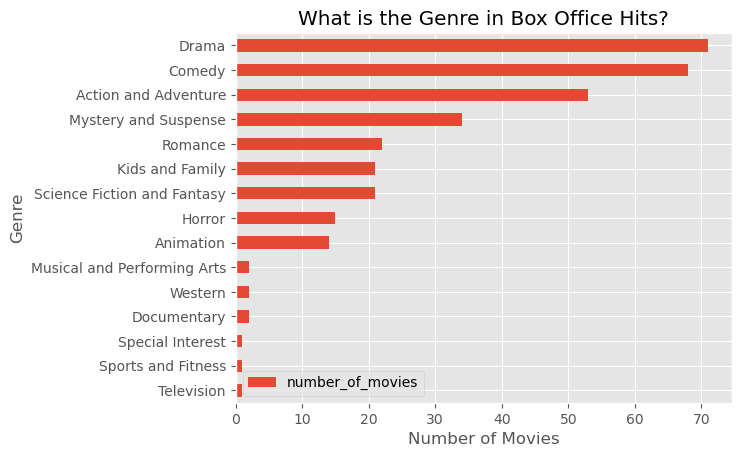

In [64]:
#calculate what genre appears most in box office tops - merged

genre_dict = {}

for genre in rt_merge["genre"]:
    movie_genres = genre.split("|")
    for movie_genre in movie_genres:
        if movie_genre not in genre_dict:
            genre_dict[movie_genre] = 1
        else:
            genre_dict[movie_genre] += 1

box_office_genre = pd.DataFrame.from_dict(genre_dict, orient='index',columns=["number_of_movies"])

df = box_office_genre.sort_values(by="number_of_movies")
df.plot(kind="barh")
plt.xticks(rotation=0)
plt.ylabel("Genre")
plt.xlabel("Number of Movies")
plt.title("What is the Genre in Box Office Hits?")
plt.savefig("./images/genre_in_box_office_hits.png", dpi=300, bbox_inches='tight')
plt.show()

In [65]:
# Perform ANOVA using statsmodels
anova_model = smf.ols('box_office ~ C(genre)', data=rt_merge).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

anova_table

,sum_sq,df,F,PR(>F)
C(genre),2.047752e+17,49.0,0.993878,0.498985
Residual,4.078681e+17,97.0,NaN,NaN


- Genres that appear in most movies doing well in box office according to Rotten Tomatoes: Comedy, Action and Adventure, Drama.
- ANOVA test shows the differences of box office results for each genre is statistically significant (p<0.001)

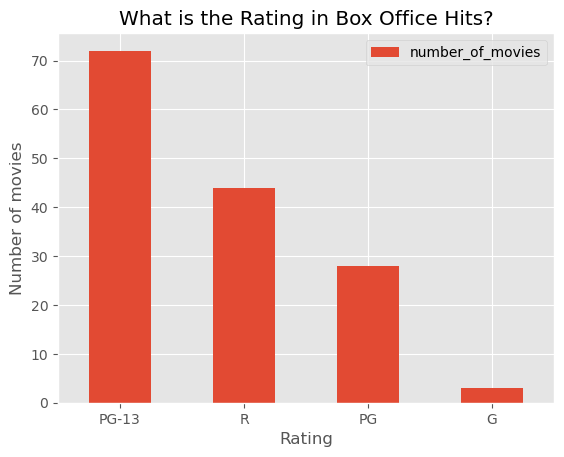

In [66]:
#from merged data
rating_dict = {}

for rating in rt_merge["rating"]:
    if rating not in rating_dict:
            rating_dict[rating] = 1
    else:
            rating_dict[rating] += 1

box_office_rating = pd.DataFrame.from_dict(rating_dict, orient='index',columns=["number_of_movies"])
df = box_office_rating.sort_values(by="number_of_movies", ascending=False)
df.plot(kind="bar")

plt.xticks(rotation=0)
plt.ylabel("Number of movies")
plt.xlabel("Rating")
plt.title("What is the Rating in Box Office Hits?")
plt.savefig("./images/rating_in_box_office_hits.png", dpi=150)
plt.show()

Movies performing above average in box office usually has PG-13 ratings.

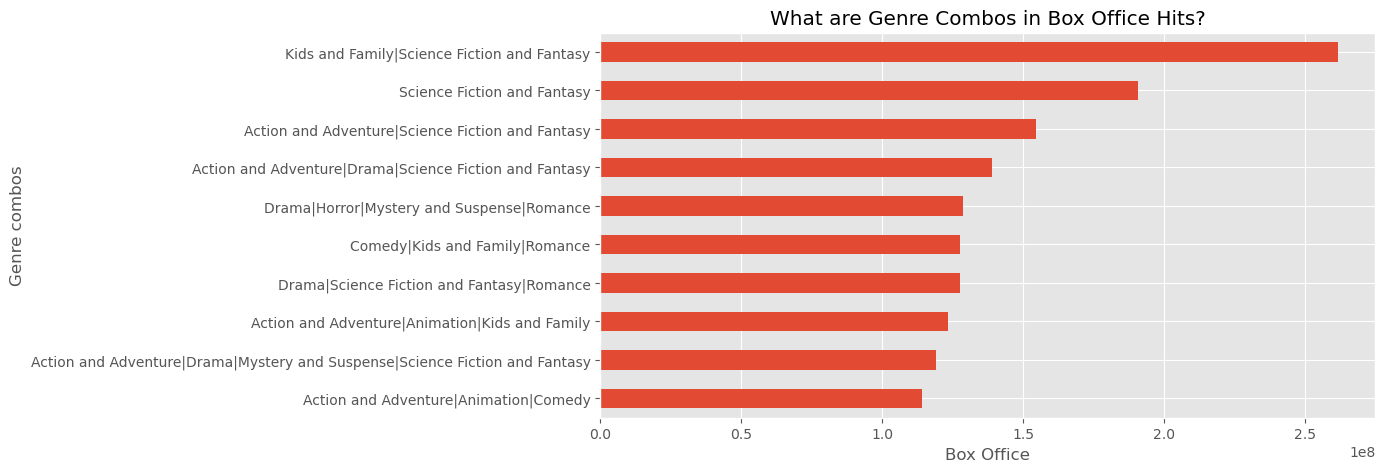

In [67]:
#combo of genres making top box office
ax = movie_info.groupby("genre")["box_office"].median().sort_values().tail(10).plot(kind="barh",figsize=(10,5))
plt.xticks(rotation=0)
plt.ylabel("Genre combos")
plt.xlabel("Box Office")
plt.title("What are Genre Combos in Box Office Hits?")
plt.savefig("./images/genre_combos_in_box_office_hits.png", dpi=300, bbox_inches='tight')
plt.show()

From Rotten Tomatoes, Action and Adventure, Drama, Romance and Science Fiction and Fantasy appear the most in this combo plot

In [68]:
tmdb_movies = tmdb_movies.sort_values(by="popularity",ascending=False)
tmdb_movies

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,year,month
23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,2018,4
11019,"[28, 53]",245891,en,John Wick,78.123,2014-10-24,John Wick,7.2,10081,2014,10
23812,"[28, 12, 16, 878, 35]",324857,en,Spider-Man: Into the Spider-Verse,60.534,2018-12-14,Spider-Man: Into the Spider-Verse,8.4,4048,2018,12
11020,"[28, 12, 14]",122917,en,The Hobbit: The Battle of the Five Armies,53.783,2014-12-17,The Hobbit: The Battle of the Five Armies,7.3,8392,2014,12
5179,"[878, 28, 12]",24428,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673,2012,5
...,...,...,...,...,...,...,...,...,...,...,...
13877,[10749],401741,en,Crème Caramel,0.600,2014-05-20,Crème Caramel,5.0,1,2014,5
13878,[878],401427,en,Elegy,0.600,2014-09-10,Elegy,5.0,1,2014,9
13879,[35],399054,en,Jaguar,0.600,2014-09-21,Jaguar,5.0,1,2014,9
13880,[],381154,en,Unleashed! A Dog Dancing Story,0.600,2014-02-13,Unleashed! A Dog Dancing Story,5.0,1,2014,2


In [69]:
genre_dict = {"28":  "Action", "12":  "Adventure", "16":  "Animation", "35":  "Comedy", "80":  "Crime", 
              "99":  "Documentary", "18":  "Drama", "10751":   "Family", "14":  "Fantasy", "36":  "History",
              "27":  "Horror", "10402":   "Music", "9648":    "Mystery", "10749":   "Romance",
              "878": "Science Fiction", "10770":   "TV Movie", "53":  "Thriller", "10752":   "War",
              "37":  "Western"}

In [70]:
def change_genres(x):
    genres = []
    genre_list = x.strip("]").strip("[").split(",")
    genre_list = [id.strip(" ") for id in genre_list]
    for genre in genre_list:
        if genre in genre_dict:
            genres.append(genre_dict[genre])
        else:
            genres.append("Other")
    return "|".join(genres)

In [71]:
tmdb_movies["genre"] = tmdb_movies["genre_ids"].apply(lambda x: change_genres(x))

In [72]:
popular_movies = tmdb_movies[tmdb_movies.popularity >= tmdb_movies["popularity"].mean()]
popular_movies = popular_movies.sort_values(by="popularity", ascending=False)
popular_movies

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,year,month,genre
23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,2018,4,Adventure|Action|Fantasy
11019,"[28, 53]",245891,en,John Wick,78.123,2014-10-24,John Wick,7.2,10081,2014,10,Action|Thriller
23812,"[28, 12, 16, 878, 35]",324857,en,Spider-Man: Into the Spider-Verse,60.534,2018-12-14,Spider-Man: Into the Spider-Verse,8.4,4048,2018,12,Action|Adventure|Animation|Science Fiction|Comedy
11020,"[28, 12, 14]",122917,en,The Hobbit: The Battle of the Five Armies,53.783,2014-12-17,The Hobbit: The Battle of the Five Armies,7.3,8392,2014,12,Action|Adventure|Fantasy
5179,"[878, 28, 12]",24428,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673,2012,5,Science Fiction|Action|Adventure
...,...,...,...,...,...,...,...,...,...,...,...,...
591,[18],44966,en,The Freebie,3.137,2010-09-17,The Freebie,4.8,12,2010,9,Drama
592,[18],39477,en,Small Town Saturday Night,3.136,2010-05-31,Small Town Saturday Night,6.2,17,2010,5,Drama
14981,"[80, 18, 53]",386465,en,Newcomer,3.135,2015-10-30,Newcomer,5.9,12,2015,10,Crime|Drama|Thriller
5826,"[99, 10402]",137563,en,A Band Called Death,3.133,2013-06-27,A Band Called Death,7.2,47,2013,6,Documentary|Music


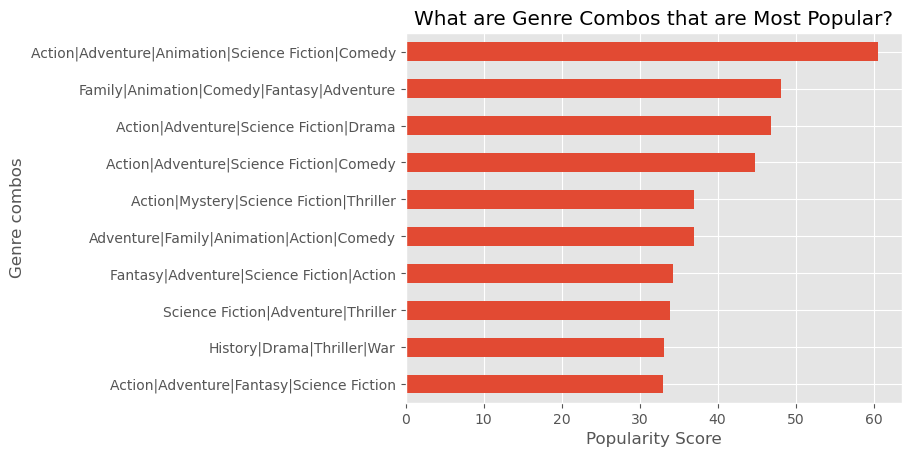

In [73]:
#combo of genres making a movie popular
ax = popular_movies.groupby("genre")["popularity"].median().sort_values().tail(10).plot(kind="barh")

plt.xticks(rotation=0)
plt.ylabel("Genre combos")
plt.xlabel("Popularity Score")
plt.title("What are Genre Combos that are Most Popular?")
plt.savefig("./images/most_popular_genre_combos_tmdb.png", dpi=300, bbox_inches='tight')
plt.show()

From TMDB dataset, Action and Adventure, Comedy, Science Fiction, and Drama appear a lot in this combo plot

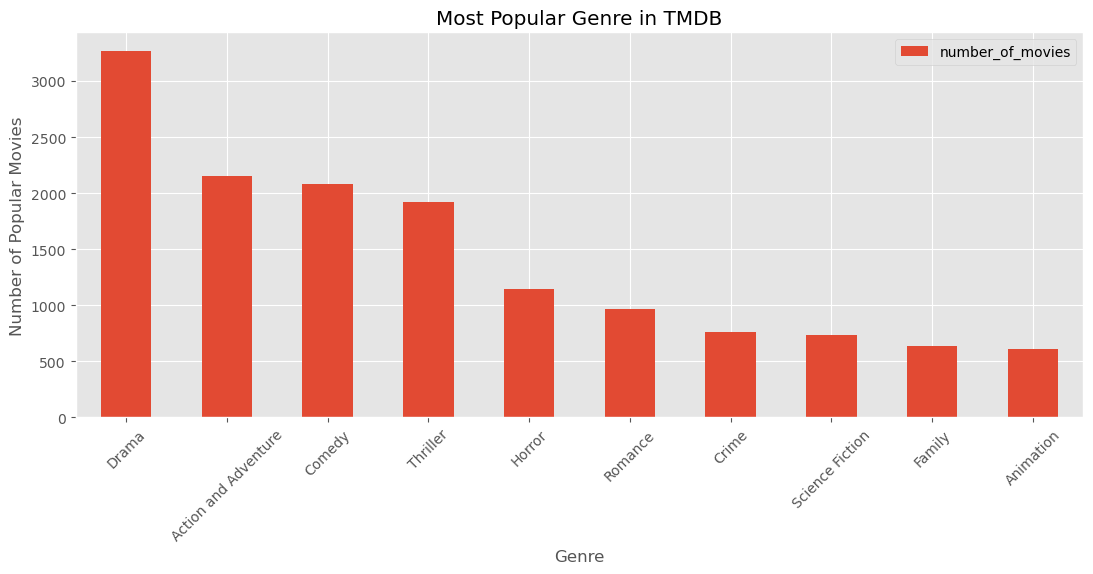

In [92]:
#individual genres in popular movies
genre_count = {}
genre_count["Action and Adventure"] = 0

for genre in popular_movies["genre"]:
    movie_genres = genre.split("|")
    for movie_genre in movie_genres:
        if movie_genre in ["Action","Adventure"]:
            genre_count["Action and Adventure"] += 1
        elif movie_genre not in genre_count:
            genre_count[movie_genre] = 1
        else:
            genre_count[movie_genre] += 1

popular_genre = pd.DataFrame.from_dict(genre_count, orient='index',columns=["number_of_movies"])
df = popular_genre.sort_values(by="number_of_movies", ascending=False).head(10)

df.plot(kind="bar", figsize=(13,5))
plt.xticks(rotation=45)
plt.ylabel("Number of Popular Movies")
plt.xlabel("Genre")
plt.title("Most Popular Genre in TMDB")
plt.savefig("./images/most_popular_genre_tmdb.png", dpi=300, bbox_inches='tight')
plt.show()

Individual genres that appear in most popular movies based on TMDB: Comedy, Action and Adventure, Drama

In [75]:
# Explode the genres to handle individual genre entries per movie
exploded_popular_movies = popular_movies.copy()
exploded_popular_movies['genre'] = exploded_popular_movies['genre'].str.split('|')
exploded_popular_movies = exploded_popular_movies.explode('genre')

# Perform ANOVA on popularity across genres
anova_model_popularity = smf.ols('popularity ~ C(genre)', data=exploded_popular_movies).fit()
anova_table_popularity = sm.stats.anova_lm(anova_model_popularity, typ=2)

anova_table_popularity

,sum_sq,df,F,PR(>F)
C(genre),38477.833274,19.0,59.965235,5.630993e-222
Residual,566289.793339,16768.0,NaN,NaN


ANOVA test indicates statistically significant effect from genre on popularity (p<0.001).

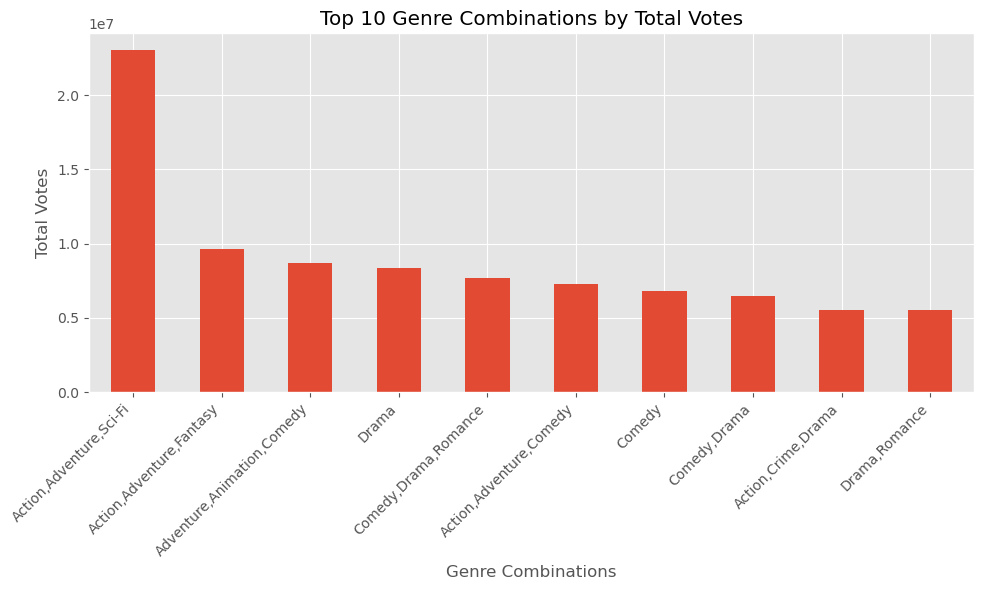

In [76]:
#load movie_summary table from imdb to analyse data
movie_summary_df = pd.read_sql("SELECT * FROM movie_summary;", conn)

#find top genre combos against numvote
genre_combo_votes = (
    movie_summary_df.groupby('genres')['numvotes']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Plot top 10 genre combinations by total votes
plt.figure(figsize=(10, 6))
genre_combo_votes.plot(kind='bar')
plt.xlabel('Genre Combinations')
plt.ylabel('Total Votes')
plt.title('Top 10 Genre Combinations by Total Votes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("./images/top_genre_combos_in_imdb.png", dpi=150)
plt.show()

Most popular genre combinations in IMDB: Action and Adventure, Sci-Fi, Comedy, Drama

In [77]:
#Split to individual genres
movie_summary_df['genres'] = movie_summary_df['genres'].str.split(',')
exploded_df = movie_summary_df.explode('genres')
exploded_df

,movie_id,genres,primary_title,averagerating,regions,numvotes
0,tt0063540,Action,Sunghursh,7.0,IN,77
0,tt0063540,Crime,Sunghursh,7.0,IN,77
0,tt0063540,Drama,Sunghursh,7.0,IN,77
1,tt0066787,Biography,One Day Before the Rainy Season,7.2,"IN,XWW",43
1,tt0066787,Drama,One Day Before the Rainy Season,7.2,"IN,XWW",43
...,...,...,...,...,...,...
73852,tt9914286,Drama,Sokagin Çocuklari,8.7,None,136
73852,tt9914286,Family,Sokagin Çocuklari,8.7,None,136
73853,tt9914642,Documentary,Albatross,8.5,None,8
73854,tt9914942,None,La vida sense la Sara Amat,6.6,None,5


In [78]:
# in this dataset, number of movies in the sample size (based on genres or regions) are not equal
# some sample set has 1 movie, some have a lot more
# find minimum number of movie via effect size

# determine cohen's d to be d=0.2 to be confident that the small differences in average ratings 
# and votes aren't just due to random variation
# 95% confidence and 80% power

from scipy.stats import norm

# Define parameters
z_alpha_2 = norm.ppf(1 - 0.05 / 2)  # two-tailed test, 95% confidence
z_beta = norm.ppf(0.8)  # 80% power

# Effect sizes
effect_sizes = {'Small (d=0.2)': 0.2, 'Medium (d=0.5)': 0.5, 'Large (d=0.8)': 0.8}

# Calculate required sample sizes
sample_sizes = {label: ((z_alpha_2 + z_beta) / d) ** 2 for label, d in effect_sizes.items()}
sample_sizes_df = pd.DataFrame(list(sample_sizes.items()), columns=['Effect Size', 'Minimum Sample Size (per group)'])


sample_sizes_df

,Effect Size,Minimum Sample Size (per group)
0,Small (d=0.2),196.221993
1,Medium (d=0.5),31.395519
2,Large (d=0.8),12.263875


In [79]:
# Apply the filter and aggregation for genres with at least 196 movies
filtered_exploded_df = exploded_df.groupby('genres').filter(lambda x: len(x) >= 196)

# Group by genre and calculate total votes and movie count
total_votes_by_genre = filtered_exploded_df.groupby('genres').agg(
    total_votes=('numvotes', 'sum'),
    movie_count=('movie_id', 'count')
).reset_index()


total_votes_by_genre

,genres,total_votes,movie_count
0,Action,101161682,6988
1,Adventure,84232589,3817
2,Animation,15353302,1743
3,Biography,21609446,3809
4,Comedy,74305805,17290
5,Crime,39631356,4611
6,Documentary,4739345,17753
7,Drama,119567500,30788
8,Family,8636710,3412
9,Fantasy,26335704,2126


In [80]:
# Sort by total_votes descending
top_genres_by_votes = total_votes_by_genre.sort_values(by='total_votes', ascending=False).head(10)
top_genres_by_votes

,genres,total_votes,movie_count
7,Drama,119567500,30788
0,Action,101161682,6988
1,Adventure,84232589,3817
4,Comedy,74305805,17290
19,Thriller,48155313,8217
17,Sci-Fi,42960289,2206
5,Crime,39631356,4611
16,Romance,26913873,6589
9,Fantasy,26335704,2126
14,Mystery,24657286,3039


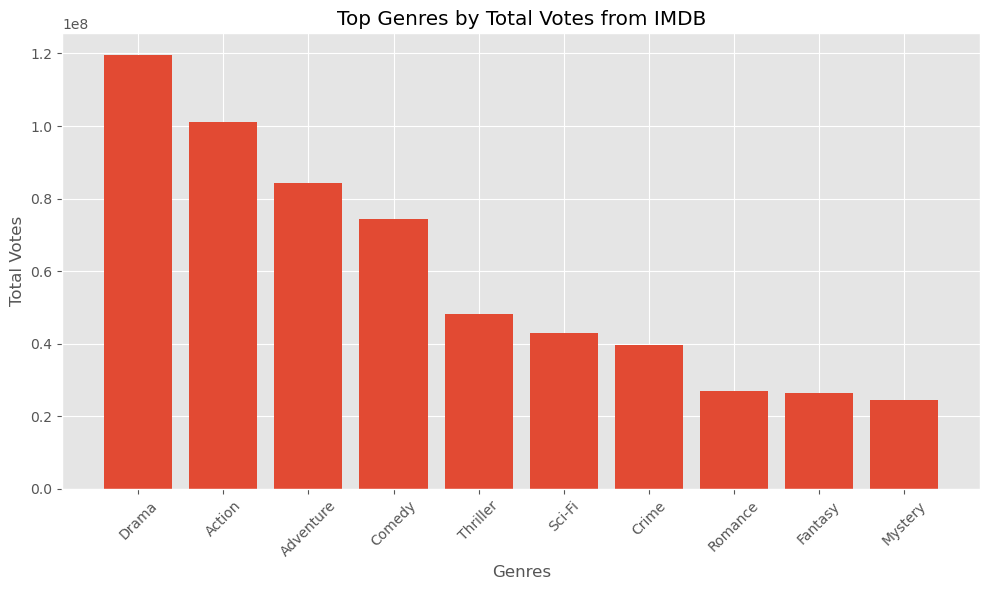

In [81]:
# Create bar plot for top genres by total votes
plt.figure(figsize=(10, 6))
plt.bar(top_genres_by_votes['genres'], top_genres_by_votes['total_votes'])
plt.xlabel('Genres')
plt.ylabel('Total Votes')
plt.title('Top Genres by Total Votes from IMDB')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./images/top_indv_genres_imdb.png", dpi=150)
plt.show()

Individual genres that appear most popular in IMDB: Drama, Action, Adventure, Comedy

In [82]:
# Prepare data by filtering only top 10 genres
top_genres = top_genres_by_votes['genres'].tolist()
top_genre_data = exploded_df[exploded_df['genres'].isin(top_genres)]

# Convert genre to categorical
top_genre_data['genres'] = top_genre_data['genres'].astype('category')

# Run OLS model and ANOVA
model = smf.ols('numvotes ~ C(genres)', data=top_genre_data).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

anova_results

/var/folders/y9/8wkgmh4d095_xph5_hcq73nw0000gn/T/ipykernel_42622/2685949355.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_genre_data['genres'] = top_genre_data['genres'].astype('category')


,sum_sq,df,F,PR(>F)
C(genres),2.168026e+12,9.0,125.721672,2.876818e-236
Residual,1.641327e+14,85661.0,NaN,NaN


The F-statistic suggests strong effect on genre on vote totals.
P < 0.001 so this effect is statistically significant

In [83]:
#create new pandas df from movie_summary to make region-based analysis
region_summary_df = pd.read_sql("SELECT * FROM movie_summary;", conn)

In [84]:
# want to analyse movies based on regions where the movie is released in
# Split and explode regions to analyze vote counts by individual region
region_summary_df['regions'] = region_summary_df['regions'].str.split(',')
region_summary_df['region_count'] = region_summary_df['regions'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Analyze correlation between number of regions and numvotes
region_vote_relation_full = region_summary_df.groupby('region_count').agg(
    average_votes=('numvotes', 'mean'),
    total_votes=('numvotes', 'sum'),
    movie_count=('movie_id', 'count')
).reset_index().sort_values(by='region_count')

region_vote_relation_full

,region_count,average_votes,total_votes,movie_count
0,0,78.101998,336151,4304
1,1,99.266191,3937592,39667
2,2,418.039361,5257263,12576
3,3,889.730034,4656847,5234
4,4,1292.857650,3641980,2817
5,5,1986.023516,3547038,1786
6,6,2105.046167,2553421,1213
7,7,2952.882540,2790474,945
8,8,3575.026471,2431018,680
9,9,4760.984645,2480473,521


In [85]:
# Apply minimum sample size threshold of 196 movies per region count group
region_vote_filtered = region_vote_relation_full[region_vote_relation_full['movie_count'] >= 196]
region_vote_filtered

,region_count,average_votes,total_votes,movie_count
0,0,78.101998,336151,4304
1,1,99.266191,3937592,39667
2,2,418.039361,5257263,12576
3,3,889.730034,4656847,5234
4,4,1292.857650,3641980,2817
5,5,1986.023516,3547038,1786
6,6,2105.046167,2553421,1213
7,7,2952.882540,2790474,945
8,8,3575.026471,2431018,680
9,9,4760.984645,2480473,521


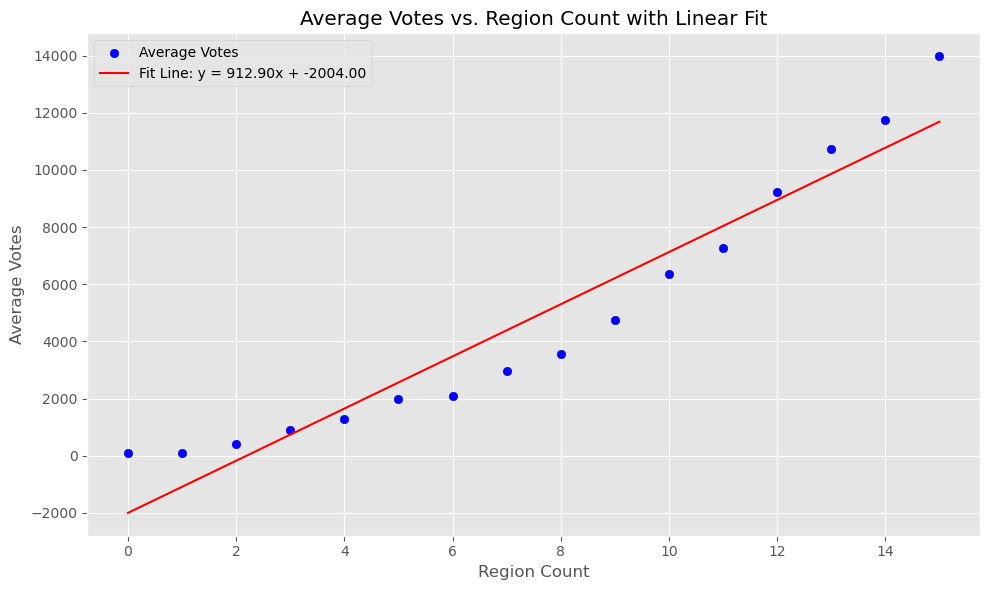

In [86]:
# Prepare data for plotting
x = region_vote_filtered['region_count']
y = region_vote_filtered['average_votes']

# Fit a linear regression line
coefficients = np.polyfit(x, y, 1)
poly_eq = np.poly1d(coefficients)
y_fit = poly_eq(x)

# Plot scatter and regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Average Votes', color='blue')
plt.plot(x, y_fit, label=f'Fit Line: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}', color='red')
plt.xlabel('Region Count')
plt.ylabel('Average Votes')
plt.title('Average Votes vs. Region Count with Linear Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./Images/Average_votes_vs_region_count_with_best_fit_line.png")
plt.show()

In [87]:
from scipy.stats import spearmanr

# Filter for region_count groups with sufficient sample size
region_vote_filtered = region_summary_df.groupby('region_count').filter(lambda x: len(x) >= 196)

# Convert region_count to categorical
region_vote_filtered['region_count'] = region_vote_filtered['region_count'].astype('category')

# Run ANOVA using statsmodels
anova_model = smf.ols('numvotes ~ C(region_count)', data=region_vote_filtered).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

# Spearman correlation for comparison
spearman_corr, spearman_p = spearmanr(region_vote_filtered['region_count'].cat.codes, region_vote_filtered['numvotes'])

anova_table
# print(f"ANOVA F-statistic: {anova_stat: .10f} \n"
#       f"ANOVA p-value: {anova_p: .10f}, \n"
#       f"Spearman correlation: {spearman_corr: .10f}, \n"
#       f"Spearman p-value: {spearman_p:.10f}")
    

,sum_sq,df,F,PR(>F)
C(region_count),1.927938e+11,15.0,1302.042572,0.0
Residual,7.070653e+11,71628.0,NaN,NaN


In [88]:
print(f"Spearman correlation: {spearman_corr: .10f}, \n"
      f"Spearman p-value: {spearman_p:.10f}")

Spearman correlation:  0.5421370566, 
Spearman p-value: 0.0000000000


- There is statistically significant differences (p<0.001) for number of votes across different region groups
- There is moderate positive correlation between the number of regions a movie is released in and number of votes. As the number of regions increases, number of votes tend to increase

## Evaluation


### Seasonality of movie release success
- Highest domestic gross median for movie releases is for releases in June, July, November. Roughly 100-150% more than other months.
- Highest worldwide gross median for movie releases is for releases in July, Nov, June. Roughly 150-250% more than other months.
- The ANOVA test indicates that, with 95% confidence, there is statistically significant difference between monthly domestic gross and worldwide gross data, which suggests that release month has an impact on domestic gross and worldwide gross.
- This is aligned with an industry phenomenon called "dump months". There are two times of the year when American filmmakers and distributors typically have lower commercial and critical expectations for new theatrical releases. During these periods, domestic audiences are generally smaller compared to the rest of the year. January and February are most often characterized this way, with August and September occasionally included.

### Genre of successful movies

- Genre of movies that consistently appear as most highly-voted or make above average in box offices, are Drama, Comedy, Action and Adventure. This is both true for genre combinations and individual genre analysis.
- ANOVA test on data from IMDB shows large F-statistic, which suggests strong effect from genre on vote total with p<0.001.
- ANOVA test on data from Rotten Tomatoes shows the differences of box office results for each genre is statistically significant (p<0.001)
- ANOVA test on data from TMDB indicates genre has a statistically significant effect on popularity (p<0.001).
- Running data models on dataset from IMDB, Rotten Tomatoes, and TMDB generate similar results, although the users of these sites are quite different, which means that bias has been minimised.

>IMDB:
> - Older audience: Skews to slightly older demographics as IMDbs has been around since the early 1990s.
> - Cinephiles: IMDB only accepts ratings from registered users and it has weighted ratings, so not all votes carry equal weight.

> Rotten Tomatoes:

> - General Audience: Many casual moviegoers use Rotten Tomatoes to get a quick sense of a movie's quality through its aggregate score.
> - Critics and Reviewers: Professional critics often contribute reviews that form the basis of the Tomatometer score.
> - Industry Professionals: Filmmakers, marketers, and studios might use Rotten Tomatoes to gauge critical reception and audience response.

> TMDB (The Movie Database):

> - Film Enthusiasts and Hobbyists: TMDB users often include more dedicated movie and TV show fans who enjoy contributing to and maintaining a comprehensive database.
> - Developers and Tech-Savvy Users: TMDB offers a robust API that developers use to integrate movie and TV show data into their applications.
> - Content Creators and Researchers: People creating content or conducting research might use TMDB for its extensive and detailed information on movies, TV shows, actors, and crew members.



### Investing in production budget and marketing to increase potential for movie success
- Popularity has a quite high correlation to domestic gross and foreign gross (0.53 - 0.55). This means that focusing on marketing is essential to increase popularity of the movie to increase viewing.
- From modelling The Numbers dataset, we see that the worldwide gross is always higher than domestic gross no matter the month. This is because the worldwide market size is always bigger than domestic. Thus, capturing worldwide market should be an objective to increase potential earnings.
- We also see that there is a strong positive relationship between production budget and domestic as well as worldwide gross. Higher production budget may indicate better production quality and more well-known/ qualified talents or crew hired for production.
    > R-squared = 0.631.
    > For every \\$1.00 increase in budget > \\$3.43 increase in worldwide gross (p<0.001)
- From modelling IMDb dataset, we see that: the more regions a movie is released in, the number of votes (positive audience reception) tend to increase.
    > ANOVA test indicates that there is statistically significant differences (p<0.001) for number of votes across different region count groups
- Therefore, in order to capture bigger box office earnings and positive audience reception, Microsoft needs to accommodate medium to large budget, and look at ways to expand market for the movie. For example, release in more regions, foreign cultural references, foreign language subtitles, etc. Large markets include global Chinese and Indian viewers.


## Conclusions

### Recommendations
- Plan to release first movie in June, July, or November
- Pick main genre of movie to be Drama - there can be a combination with Action/ Adventure or Comedy.
- Invest in production budget to improve movie quality, and invest in marketing to boost popularity of movie before and during release. Release in more countries wherever possible. It is worth inserting cultural easter eggs or relatable references to capture large global markets, especially the Chinese and/or Indian populations.

### Future steps
- Determine which movies are more popular and well-liked by audience: standalone vs sequel/ part of franchise.
- Analyse the combinations of people working in successful movies to identify dream team, especially for production and behind-the-scenes.
- Analyse what type of movies didn't do well in box office and why.